# Helper functions for the de-dispersion code

### Aug 04, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
# import pyrex.custom.analysis
# import pyrex.custom.araroot as araroot



Welcome to JupyROOT 6.18/04


In [2]:
import pyrex.custom.ara as ara
from pyrex.internal_functions import (normalize, complex_bilinear_interp,
                                      complex_interp)

In [3]:
# ara_antenna = ara.antenna.VPOL_RESPONSE_DATA
VPOL_DATA_FILE = os.path.join(ara.antenna.ARA_DATA_DIR,
                              "ARA_bicone6in_output_MY_fixed.txt")
VPOL_THETA_RESPONSE_DATA = ara.antenna._read_arasim_antenna_data(VPOL_DATA_FILE)
VPOL_RESPONSE_DATA = (
    VPOL_THETA_RESPONSE_DATA[0],
    np.zeros(VPOL_THETA_RESPONSE_DATA[0].shape),
    *VPOL_THETA_RESPONSE_DATA[1:]
)
ara_antenna = VPOL_RESPONSE_DATA

theta_response = ara_antenna[0]
phi_response = ara_antenna[1]
response_freqs = ara_antenna[2]
response_zens = ara_antenna[3]
response_azis = ara_antenna[4]

In [4]:
def directional_response(theta, phi, polarization=np.array([0,0,1])):
        """
        Generate the (complex) frequency-dependent directional response.
        For given angles and polarization direction, use the model of the
        directional and polarization gains of the antenna to generate a
        function for the interpolated response of the antenna with respect to
        frequency. Used with the `frequency_response` method to calculate
        effective heights.
        Parameters
        ----------
        theta : float
            Polar angle (radians) from which a signal is arriving.
        phi : float
            Azimuthal angle (radians) from which a signal is arriving.
        polarization : array_like
            Normalized polarization vector in the antenna coordinate system.
        Returns
        -------
        function
            A function which returns complex-valued voltage gains for given
            frequencies, using the values of incoming angle and polarization.
        See Also
        --------
        ARAAntenna.frequency_response : Calculate the (complex) frequency
                                        response of the antenna.
        """
#         e_theta = [np.cos(theta) * np.cos(phi),
#                    np.cos(theta) * np.sin(phi),
#                    -np.sin(theta)]
#         e_phi = [-np.sin(phi), np.cos(phi), 0]
#         theta_factor = np.dot(polarization, e_theta)
#         phi_factor = np.dot(polarization, e_phi)
        theta_factor = 1
        phi_factor = 1
        theta_gains = complex_bilinear_interp(
            x=np.degrees(theta), y=np.degrees(phi),
            xp=response_zens,
            yp=response_azis,
            fp=theta_response,
            method='cartesian'
        )
        phi_gains = complex_bilinear_interp(
            x=np.degrees(theta), y=np.degrees(phi),
            xp=response_zens,
            yp=response_azis,
            fp=phi_response,
            method='cartesian'
        )
        freq_interpolator = lambda frequencies: complex_interp(
            x=frequencies, xp=response_freqs,
            fp=theta_factor*theta_gains + phi_factor*phi_gains,
            method='euler', outer=0
        )
        return freq_interpolator
    
def frequency_response(frequencies):
    """
    Calculate the (complex) frequency response of the antenna.
    Rather than handling the entire frequency response of the antenna, this
    method is being used to convert the frequency-dependent gains from the
    `directional_response` method into effective heights.
    Parameters
    ----------
    frequencies : array_like
        1D array of frequencies (Hz) at which to calculate gains.
    Returns
    -------
    array_like
        Complex gains in voltage for the given `frequencies`.
    See Also
    --------
    ARAAntenna.directional_response : Generate the (complex) frequency
                                      dependent directional response.
    """
    # From AraSim GaintoHeight function, with gain calculation moved to
    # the directional_response method.
    # gain=4*pi*A_eff/lambda^2 and h_eff=2*sqrt(A_eff*Z_rx/Z_air)
    # Then 0.5 to calculate power with heff (cancels 2 above)
    heff = np.zeros(len(frequencies))
    # The index of refraction in this calculation should be the index of
    # the ice used in the production of the antenna model.
    n = 1.78
    heff[frequencies!=0] = np.sqrt((3e8/frequencies[frequencies!=0]/n)**2
                                   * n*50/377 /(4*np.pi))
    return heff

## Debug FFT

### FFT function

In [5]:
def doFFT(time, volts):
    fft = scipy.fft.rfft(np.array(volts))
    dT = abs(time[1]-time[0])
    freq = 1000*scipy.fft.rfftfreq(n=len(time), d=dT)
    return fft, freq, dT
    

### Inverse FFT

In [6]:
def doInvFFT(spectrum):
    fft_i_v= scipy.fft.irfft(spectrum)
    return fft_i_v
    

## Get filter response

In [7]:
def interpolate_filter(frequencies):
        """
        Generate interpolated filter values for given frequencies.
        Calculate the interpolated values of the antenna system's filter gain
        data for some frequencies.
        Parameters
        ----------
        frequencies : array_like
            1D array of frequencies (Hz) at which to calculate gains.
        Returns
        -------
        array_like
            Complex filter gain in voltage for the given `frequencies`.
        """
        ARAfilter = ara.antenna.ALL_FILTERS_DATA
        filt_response = ARAfilter[0]
        filt_freqs = ARAfilter[1]
        return complex_interp(
            x=frequencies, xp=filt_freqs, fp=filt_response,
            method='euler', outer=0
        )

## Define de-dispersion function

In [8]:
def deDisperse_filter(time, voltage):
    fft_v, fft_f, dT = doFFT(time,voltage)
    response = np.array(interpolate_filter(fft_f*1E6))
    response = np.divide(response,abs(response))
    deDis_wf = np.divide(fft_v,response)
    deDis_wf = np.nan_to_num(deDis_wf)
    deDis_wf = doInvFFT(deDis_wf)
    return time, deDis_wf


# Antenna response de-dispersion

## Define function

In [9]:
def deDisperse_antenna(time, voltage, theta, phi):
    fft_v, fft_f, dT = doFFT(time, voltage)
    dir_res = directional_response(theta,phi)(fft_f*1E6)
    heff = dir_res * frequency_response(fft_f*1E6)
    response = dir_res*heff
    response = np.divide(response,abs(response))
    deDis_wf = np.divide(fft_v,response)
    deDis_wf = np.nan_to_num(deDis_wf)
    deDis_wf = doInvFFT(deDis_wf)
    return time, deDis_wf

## Simultaneous de-dispersion

In [10]:
def deDisperse(time, voltage, theta, phi):
    fft_v, fft_f, dT = doFFT(time,voltage)
    response_filter = np.array(interpolate_filter(fft_f*1E6))
    dir_res = directional_response(theta,phi)(fft_f*1E6)
    heff = dir_res * frequency_response(fft_f*1E6)
    response_antenna = dir_res*heff
    response = response_filter + response_antenna
    response = np.divide(response,abs(response))
    deDis_wf = np.divide(fft_v,response)
    deDis_wf = np.nan_to_num(deDis_wf)
    deDis_wf = doInvFFT(deDis_wf)
    return time, deDis_wf

# Debug using impulse response

### Create impulse

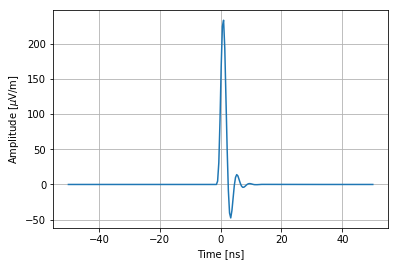

In [14]:
from scipy import signal
imp = signal.unit_impulse(256, 125)
b, a = signal.butter(4, 0.2)
response = 1E3*signal.lfilter(b, a, imp)
t = np.linspace(-50, 50, 256)
# plt.plot(np.arange(-50, 50), imp)
plt.plot(t, response)
plt.xlabel('Time [ns]')
plt.ylabel('Amplitude [$\mu$V/m]')
plt.grid(True)


Use PyREx to apply ARA electronics response

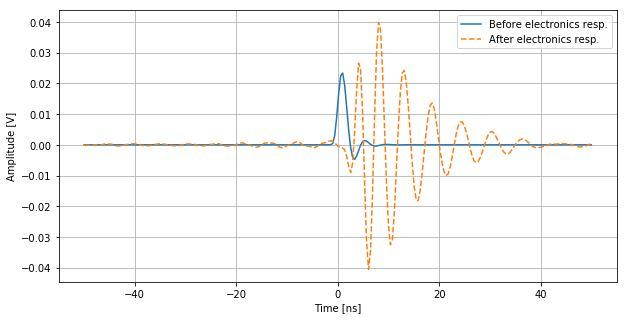

In [71]:
from scipy import signal
plt.figure(figsize=(10,5))

sig = pyrex.Signal(t*1E-9,response*1E-6,'voltage') # times in seconds
ant = ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
sig = ant.apply_response(sig, direction=np.array([1,0,0]), polarization=np.array([0,0,-1]), force_real=True)
output = ant.front_end(sig)
plt.plot(t, response/1E4, label="Before electronics resp.")
plt.plot(output.times*1E9,output.values, "--", label="After electronics resp.")
plt.grid(True)
plt.xlabel('Time [ns]')
plt.ylabel('Amplitude [V]')
plt.legend()


### Now, let's try to de-disperse and see what we get

#### Filter dedp.

In [72]:
time = output.times*1E9 #in ns
voltage = output.values*1E3 #in mV
# plt.plot(time,voltage)

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


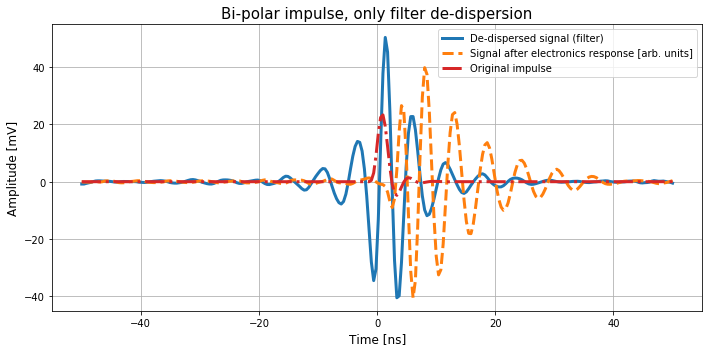

In [73]:
plt.figure(figsize=(10,5))
plt.xlabel("Time [ns]", fontsize=12)
plt.ylabel("Amplitude [mV]", fontsize=12)

deD_t, deD_v = deDisperse_filter(time,voltage)
plt.plot(deD_t,deD_v,lw=3,label = "De-dispersed signal (filter)")
plt.plot(time, voltage,"--",lw=3, label = "Signal after electronics response [arb. units]")
plt.plot(t, response/1E1, "-.",lw=3,color="C3", label="Original impulse")
plt.grid(True)
plt.legend()
plt.title("Bi-polar impulse, only filter de-dispersion", fontsize=15)
plt.tight_layout()


#### Antenna dedp.


/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


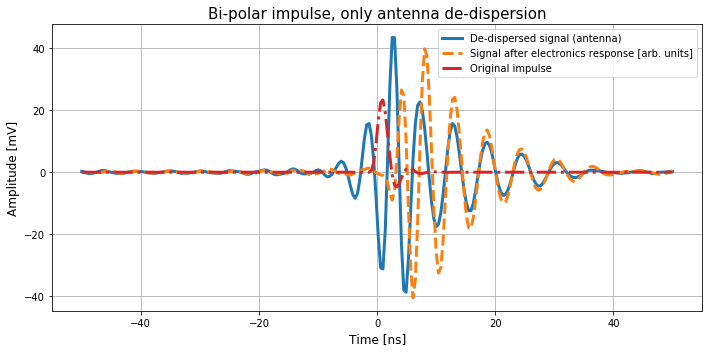

In [74]:
phi = np.deg2rad(0)
theta = np.deg2rad(90)

plt.figure(figsize=(10,5))
plt.xlabel("Time [ns]", fontsize=12)
plt.ylabel("Amplitude [mV]", fontsize=12)
deD_t, deD_v = deDisperse_antenna(time, voltage, theta, phi)
plt.plot(deD_t,deD_v,lw=3,label = "De-dispersed signal (antenna)")
plt.plot(time, voltage,"--",lw=3, label = "Signal after electronics response [arb. units]")
plt.plot(t, response/1E1, "-.",lw=3,color="C3", label="Original impulse")
plt.grid(True)
# plt.xlim(0,100)
plt.legend()
plt.title("Bi-polar impulse, only antenna de-dispersion", fontsize=15)
plt.tight_layout()


#### Antenna + filter dedp.


/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


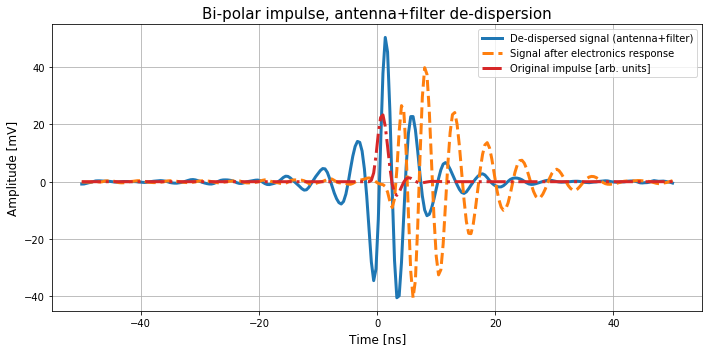

In [77]:
plt.figure(figsize=(10,5))
plt.xlabel("Time [ns]", fontsize=12)
plt.ylabel("Amplitude [mV]", fontsize=12)
deD_t, deD_v = deDisperse(time, voltage, theta, phi)
# deD_t, deD_v = deDisperse_filter(deD_t, deD_v)

plt.plot(deD_t,deD_v,lw=3,label = "De-dispersed signal (antenna+filter)")
plt.plot(time, voltage,"--",lw=3, label = "Signal after electronics response")
plt.plot(t, response/1E1, "-.",lw=3,color="C3", label="Original impulse [arb. units]")

plt.grid(True)
# plt.xlim(0,100)
plt.legend()
plt.title("Bi-polar impulse, antenna+filter de-dispersion", fontsize=15)
plt.tight_layout()
plt.savefig("./plots/impulse_DDP.png", dpi = 100)

### It seems to be doing a great job with the artificial impulse. Now, let's apply it on a simulated event (w/noise)

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


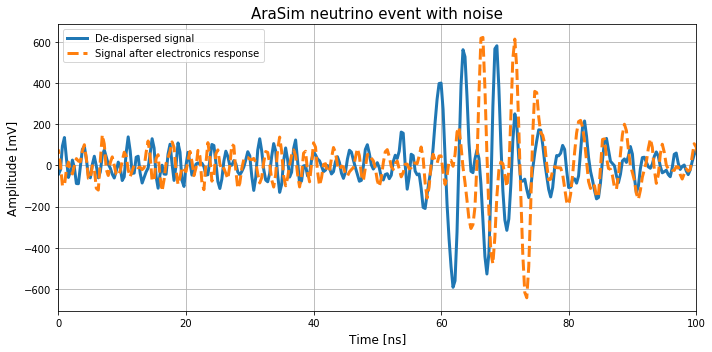

In [76]:
wform = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/wform_forDebug.pkl")
plt.figure(figsize=(10,5))
plt.xlabel("Time [ns]", fontsize=12)
plt.ylabel("Amplitude [mV]", fontsize=12)

deD_t, deD_v = deDisperse(wform["time"], wform.voltage, theta, phi)
plt.plot(deD_t,deD_v,lw=3,label = "De-dispersed signal")
plt.plot(wform["time"], wform.voltage,"--",lw=3, label = "Signal after electronics response")
plt.xlim(0,100)
plt.legend()
plt.grid(True)
plt.title("AraSim neutrino event with noise", fontsize=15)
plt.tight_layout()
plt.savefig("./plots/AraSim_noise_DDP.png", dpi = 100)

## Comments

It seems that it works for an artificial impulse. However, when I use an AraSim event, something seems to go wrong, and I don't understand why.

Amy suggested also applying the inverse of the gains, so I will do that tomorrow